In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm 
from PIL import Image

from crp.image import imgify, vis_opaque_img, plot_grid
#from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names, get_output_shapes
from crp.cache import ImageCache
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
from crp.graph import trace_model_graph
from crp.attribution import AttributionGraph

from tigramite import data_processing as pp
#from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc_torch import GPDCtorch
from tigramite.independence_tests.cmiknn import CMIknn
#from tigramite.causal_effects import CausalEffects
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.regressionCI import RegressionCI

%matplotlib inline

In [2]:
from shape_covnet import train_network #ShapeConvolutionalNeuralNetwork,
from causal_dsprites_dataset import get_datasets, CausalDSpritesDataset
from lingam import make_lingam
from cmiknnmixed import CMIknnMixed
%reload_ext autoreload
%autoreload 2

In [3]:
BATCH_SIZE = 128
datasets = get_datasets(BATCH_SIZE) #rect: 7.6%, ellipse 92.78%, heart: 4.4%

In [4]:
model = train_network(datasets["train"]["loader"], BATCH_SIZE, load=True, path="biased_dsprites.pickle")
[i.shape for i in model.parameters()]

cpu


[torch.Size([6, 1, 9, 9]),
 torch.Size([6]),
 torch.Size([6, 6, 9, 9]),
 torch.Size([6]),
 torch.Size([6, 384]),
 torch.Size([6]),
 torch.Size([3, 6]),
 torch.Size([3])]

In [152]:
from torch.utils.data import DataLoader

dsprites_dataset_train_unbiased = CausalDSpritesDataset(
    train=True, with_watermark=True, causal=False, verbose=False
)

train_unbiased_loader = DataLoader(
    dsprites_dataset_train_unbiased, batch_size=BATCH_SIZE, shuffle=True
)
model = train_network(
    train_unbiased_loader,
    BATCH_SIZE,
    load=True,
    path="unbiased_dsprites.pickle",
)

cpu


In [5]:
# Feature Visualization:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#canonizers = [SequentialMergeBatchNorm()]

composite = EpsilonPlusFlat()

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names }

attribution = CondAttribution(model, no_param_grad=True)

def vis_simple(data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=rf,alpha=0.0, vis_th=0.0, crop_th=0.0)


fv_path = "crp-stuff/biased_dsprites" #unbiased_dsprites
fv = FeatureVisualization(attribution, datasets["test_unbiased"]["ds"], layer_map, path=fv_path)

output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

layer_names


['convolutional_layers.0',
 'convolutional_layers.2',
 'linear_layers.0',
 'linear_layers.2']

In [7]:
# RUN REFERENCE IMAGE COMPUTATION
saved_files = fv.run(composite, 0, len(datasets["test_unbiased"]["ds"]), 20, 100)

Running Analysis...


100%|██████████| 15000/15000 [09:58<00:00, 25.08it/s]


100%|██████████| 1800/1800 [00:00<00:00, 1892.25it/s]


In [6]:
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

cache = ImageCache(path="biased-cache") #unbiased-cache

fv = FeatureVisualization(attribution, datasets["test_unbiased"]["ds"], layer_map, path=fv_path, cache=cache)


layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

fv.precompute_ref(layer_id_map,  plot_list=[vis_simple], mode="relevance", r_range=(0, 10),
                  composite=composite, batch_size=32, stats=True)

Layer: convolutional_layers.0


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 11.29it/s]


Layer: convolutional_layers.2


  0%|          | 0/6 [00:00<?, ?it/s]/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/zennit/image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)
100%|██████████| 6/6 [00:00<00:00, 10.32it/s]


Layer: linear_layers.0


100%|██████████| 6/6 [00:00<00:00,  9.71it/s]


Layer: linear_layers.2


100%|██████████| 3/3 [00:00<00:00,  9.83it/s]


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


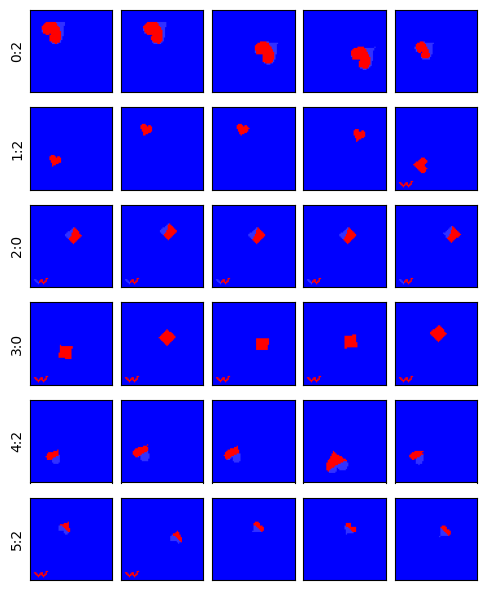

In [248]:
def vis_simple(data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=rf,alpha=0.1, vis_th=0.0, crop_th=0.0)

no_ref_samples = 5
def make_all_relevances(cond_layer, neurons):
    all_refs = {}
    for i in neurons:
        targets, rel = fv.compute_stats(i, cond_layer, "relevance", top_N=1, norm=True)
        ref_c = fv.get_stats_reference(
            i,
            cond_layer,
            [targets],
            "relevance",
            (0, no_ref_samples),
            composite=composite,
            rf=False,
            plot_fn=vis_simple,
        )
        all_refs[f"{i}:{targets}"] = ref_c[f"{i}:{targets}"]
    plot_grid(all_refs, figsize=(no_ref_samples, len(neurons)), padding=True, symmetric=True)


make_all_relevances("convolutional_layers.0", range(6))

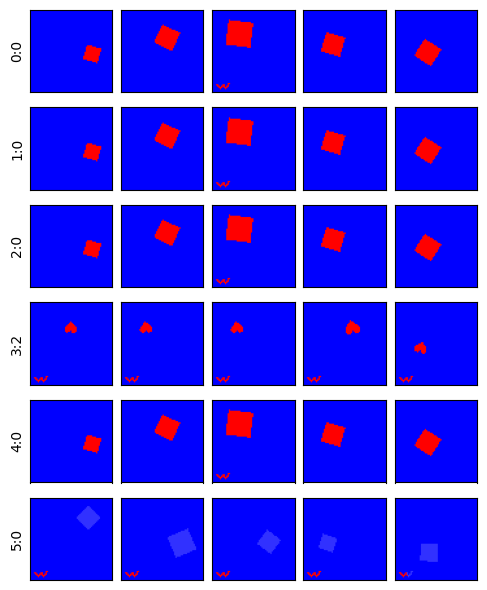

In [249]:
make_all_relevances("convolutional_layers.2",range(6))

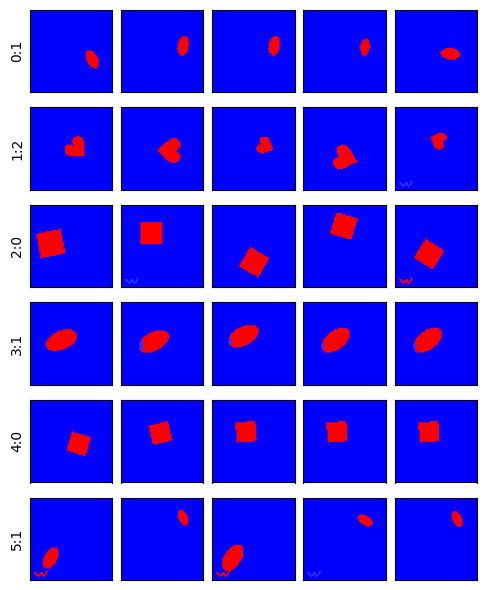

In [12]:
make_all_relevances("linear_layers.0",range(6))

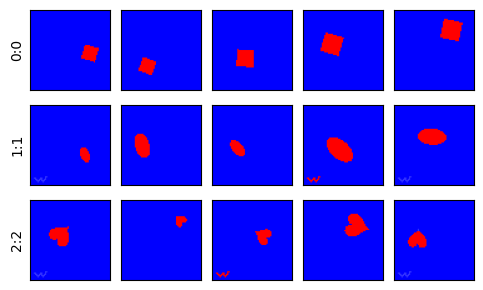

In [14]:
make_all_relevances("linear_layers.2", range(3))

In [8]:
def relevance_for_image(label, image):
    all_refs = {}
    all_refs["sample"] = torch.ones((6,64,64))
    all_refs["sample"][:] = image
    for l in layer_id_map.keys():
        conditions = [{"y": [label], l: [i]} for i in layer_id_map[l]]
        attr = attribution(
            image,
            conditions,
            composite,
            record_layer=layer_names,
        )
        all_refs[f"{l[:4]}_{l[-1]}"] = torch.zeros((6,64,64))
        for h in range(attr.heatmap.shape[0]):
            all_refs[f"{l[:4]}_{l[-1]}"][h] = attr.heatmap[h]

    plot_grid(all_refs, figsize=(6, 6), padding=False)


tensor([[ 1.1402, -1.1026, -1.2808]])
latents: [ 0  2 30  6  9],
 watermark: True, 
 prediction:0  
 
 convolutional_layers.0: 
 2: 42.75%, 5: 20.02%, 3: 17.44%, 4: 17.36%, 0: 2.42%, 1: 0.0% 
 
 convolutional_layers.2: 
 5: 100.0%, 3: 0.0%, 4: 0.0%, 0: 0.0%, 2: 0.0%, 1: 0.0% 
 
 linear_layers.0: 
 0: 87.3%, 1: 0.0%, 4: 0.0%, 3: 0.0%, 2: 0.0%, 5: -12.7% 
 
 linear_layers.2: 
 0: 100.0%, 1: 0.0%, 2: 0.0% 


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


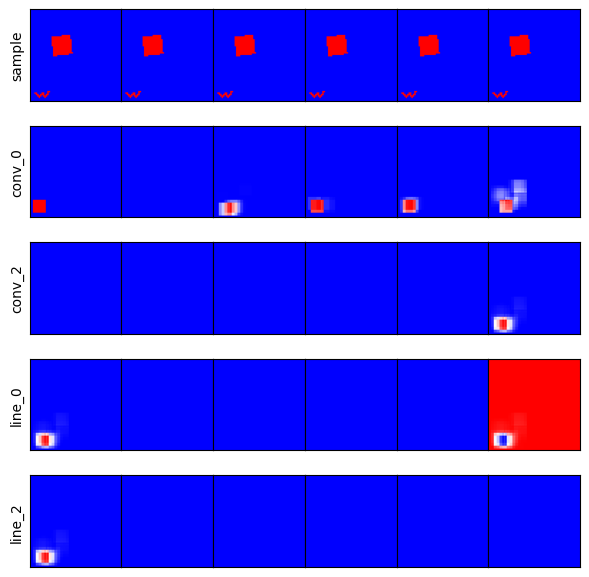

In [9]:
index = np.random.randint(0, len(datasets["test_unbiased"]["ds"]))
datum = datasets["test_unbiased"]["ds"][index]
label = datum[1]
img = datum[0]
latents, watermark = datasets["test_unbiased"]["ds"].get_item_info(index)
sample = img.view(1, 1, 64, 64)
sample.requires_grad = True
result_string = ""
output = model(sample)
print(output.data)
pred = output.data.max(1, keepdim=True)[1]
res = pred[0][0].tolist()
conditions = [{"y": [res]}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)
for cond_layer in layer_id_map.keys():
    rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
    # concepts ordered by relevance and their contribution to final classification in percent
    rel_values, concept_ids = torch.topk(rel_c[0], len(layer_id_map[cond_layer]))
    result_string += f'\n \n {cond_layer}: \n {", ".join([str(int(concept_ids[i])) + ": " + str(round(float(rel_values[i])*100, 2)) + "%" for i in range(len(layer_id_map[cond_layer]))])} '
print(
    f'latents: {latents},\n watermark: {watermark}, \n prediction:{res}  {result_string}'
)
relevance_for_image(label, sample)

In [37]:
def get_reference_scores(img, label, layer, neurons):
    conditions = [{ 'y': [label]}]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.relevances[layer], abs_norm=True) #  activations
    return [rel_c[0][i] for i in neurons]

In [38]:
def draw_complete_ref_score_values(size, layers, shape=None):
    variables = []
    indices = []
    while len(variables) < size:
        # test_unbiased, train, no_watermark
        ds = datasets["test_unbiased"]["ds"]
        index = np.random.randint(0, len(ds))
        indices.append(index)
        latents, watermark = ds.get_item_info(index)
        # only specific shape
        img, label = ds[index]
        if shape is not None and label != shape:
            continue
        sample = img.view(1, 1, 64, 64)
        sample.requires_grad = True
        in_variables = []
        for x in layers:
            cond_layer = x[0]
            if cond_layer == "factors":
                res = latents.tolist() + [int(watermark)]
            elif cond_layer == "prediction":
                output = model(sample)
                if len(x[1]) == 1:
                    pred = output.data.max(1, keepdim=True)[1]
                    res = pred[0].tolist()
                else:
                    res = output.data[0].tolist()
            else:
                neurons = x[1]
                res = get_reference_scores(sample, label, cond_layer, neurons)
            in_variables += res

        if not np.all(np.isfinite(in_variables)):
            print(index)
        variables.append(in_variables)
    return np.array(variables, dtype=np.float64), np.array(indices, dtype=np.int64)

In [39]:
def no_constants_df(layers, shape=None, standardize=True):
    all_var_names = np.array(
        [f"{nam[0][0:4]}{nam[0][-1]}_{k}" for nam in layers for k in nam[1]]
    )
    data, indices = draw_complete_ref_score_values(2000, layers, shape)
    empty_vars = []
    var_names = all_var_names
    for var in range(len(all_var_names)):
        not_constant = np.where(data[:,var] != data[0,var])[0].shape[0]
        if not_constant < 5: 
            empty_vars.append(var)
        elif all_var_names[var][0:4] != "fact":
            X = data[:,var]
            data[:,var] = (X - X.mean())/(X.std())
    var_names = np.delete(all_var_names, empty_vars)
    data = np.delete(data, empty_vars, axis=1)
    layers = [
        [nam[0], [k for k in nam[1] if f"{nam[0][0:4]}{nam[0][-1]}_{k}" in var_names]]
        for nam in layers
    ]
    # sanity test that variable names are correct
    print(
        f"all variables: {all_var_names.shape},\n non-constant variables: {var_names.shape},\
              \n shape of dataset: {data.shape} \n new layers: \n{layers}\n var names = {var_names}"
    )
    types = np.zeros(data.shape, dtype="int")
    if layers[0][0] == "factors": 
        types[:, :len(layers[0][1])] = 1
    if var_names[-1] == "predn_class":
        types[:, -1] = 1
    dataframe = pp.DataFrame(data, var_names=var_names, data_type=types)
    return dataframe, var_names, layers, indices

In [47]:
def make_nn_link_assumptions(layers, same_layer=False, all_factors=False):
    link_assumptions = {}
    index = 0
    layerEnd = 0
    for l in range(len(layers)):
        previousEnd = layerEnd
        layerEnd += len(layers[l][1])
        for neuron in layers[l][1]:
            if same_layer or (all_factors and layers[l][0] == "factors"):
                link_assumptions[index] = {}
                for i in range(previousEnd, layerEnd):
                    if i != index:
                        link_assumptions[index][(i, 0)] = "o?o"
                        if i not in link_assumptions:
                            link_assumptions[i] = {}
                        link_assumptions[i][(index, 0)] = "o?o"
            if l + 1 < len(layers):
                if index not in link_assumptions:
                    link_assumptions[index] = {}
                otherneurons = len(layers[l + 1][1])
                if all_factors and l == 0:
                    otherneurons = sum(len(layers[i][1]) for i in range(1, len(layers)))
                for other_neuron in range(otherneurons):
                    othern = layerEnd + other_neuron
                    link_assumptions[index][(othern, 0)] = "<?-"
                    if othern not in link_assumptions:
                        link_assumptions[othern] = {}
                    link_assumptions[othern][(index, 0)] = "-?>"
                index += 1
    return link_assumptions

(10000, 6)


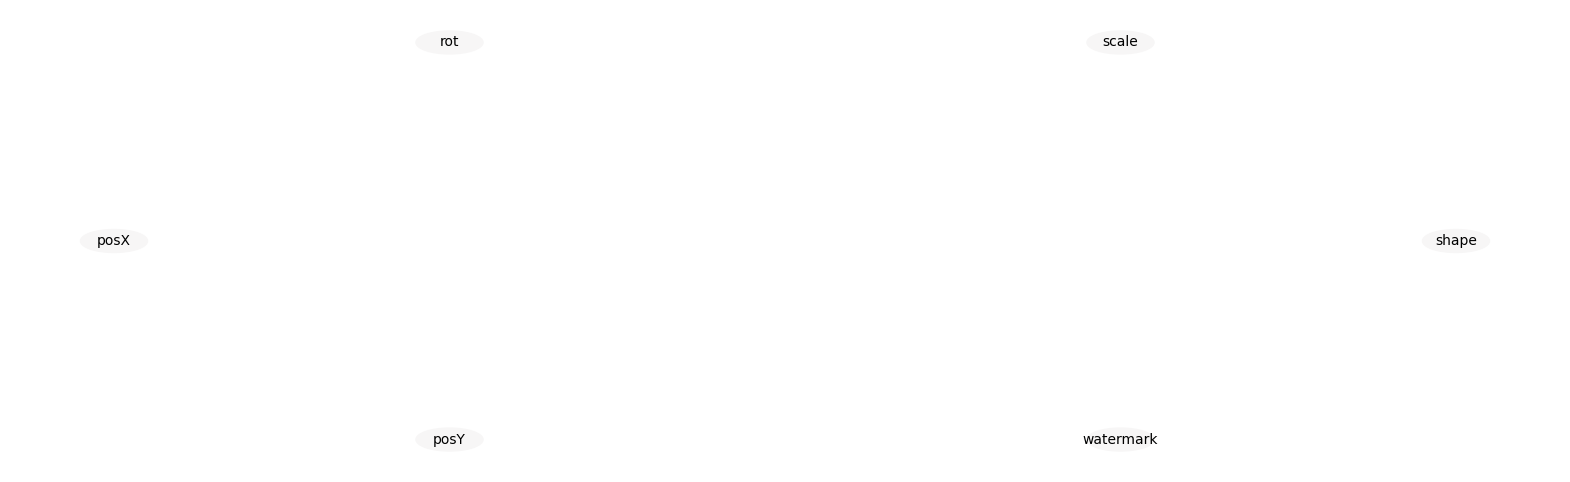

In [30]:
def generating_factors_causal_graph():
    data = []
    for i in range(10000):    
        ds = datasets["test_unbiased"]["ds"]   
        index = np.random.randint(0, len(ds))
        latents, watermark = ds.get_item_info(index)
        res = latents.tolist() + [int(watermark)]
        data.append(res)
    data = np.array(data, dtype="int")
    print(data.shape)
    var_names = ['shape', 'scale', 'rot', 'posX', 'posY', 'watermark']
    types = np.ones(data.shape, dtype="int")
    dataframe = pp.DataFrame(data, var_names=var_names)#, data_type=types)
    #ci_test = RegressionCI()
    ci_test = RobustParCorr(significance="analytic", )
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ci_test, verbosity=0)
    results =  pcmci.run_pcalg_non_timeseries_data()
    graph_effects = make_lingam(results, data, var_names)
    tp.plot_graph(
            graph=graph_effects,
            val_matrix=results["val_matrix"],
            save_name=None,
            var_names=var_names,
            figsize=(20, 6),
            arrow_linewidth=4,
            arrowhead_size=30,
            node_size=0.1,
            node_aspect=1,
            label_fontsize=16,
            show_colorbar=False,
        )
generating_factors_causal_graph()

In [41]:
# here you can use all existing layers and accordingly the set of neurons
layers = [
    ["factors", ["shape", "scale", "rot", "posX", "posY", "watermark"]],
    #["convolutional_layers.0", range(6)],
    ["convolutional_layers.2", [5]],
    ["linear_layers.0", range(6)],
    ["linear_layers.2", range(3)],
    #["prediction",  ["rectangle", "ellipse", "heart"]] #  ["class"]],  #
]  # , ["prediction", range(3)]

dataframe, var_names, layers, indices = no_constants_df(layers)

all variables: (16,),
 non-constant variables: (16,),              
 shape of dataset: (2000, 16) 
 new layers: 
[['factors', ['shape', 'scale', 'rot', 'posX', 'posY', 'watermark']], ['convolutional_layers.2', [5]], ['linear_layers.0', [0, 1, 2, 3, 4, 5]], ['linear_layers.2', [0, 1, 2]]]
 var names = ['facts_shape' 'facts_scale' 'facts_rot' 'facts_posX' 'facts_posY'
 'facts_watermark' 'conv2_5' 'line0_0' 'line0_1' 'line0_2' 'line0_3'
 'line0_4' 'line0_5' 'line2_0' 'line2_1' 'line2_2']


In [52]:
link_assumptions

{0: {(6, 0): '<?-'},
 6: {(0, 0): '-?>',
  (1, 0): '-?>',
  (2, 0): '-?>',
  (3, 0): '-?>',
  (4, 0): '-?>',
  (5, 0): '-?>',
  (7, 0): '<?-',
  (8, 0): '<?-',
  (9, 0): '<?-',
  (10, 0): '<?-',
  (11, 0): '<?-',
  (12, 0): '<?-'},
 1: {(6, 0): '<?-'},
 2: {(6, 0): '<?-'},
 3: {(6, 0): '<?-'},
 4: {(6, 0): '<?-'},
 5: {(6, 0): '<?-'},
 7: {(6, 0): '-?>', (13, 0): '<?-', (14, 0): '<?-', (15, 0): '<?-'},
 8: {(6, 0): '-?>', (13, 0): '<?-', (14, 0): '<?-', (15, 0): '<?-'},
 9: {(6, 0): '-?>', (13, 0): '<?-', (14, 0): '<?-', (15, 0): '<?-'},
 10: {(6, 0): '-?>', (13, 0): '<?-', (14, 0): '<?-', (15, 0): '<?-'},
 11: {(6, 0): '-?>', (13, 0): '<?-', (14, 0): '<?-', (15, 0): '<?-'},
 12: {(6, 0): '-?>', (13, 0): '<?-', (14, 0): '<?-', (15, 0): '<?-'},
 13: {(7, 0): '-?>',
  (8, 0): '-?>',
  (9, 0): '-?>',
  (10, 0): '-?>',
  (11, 0): '-?>',
  (12, 0): '-?>'},
 14: {(7, 0): '-?>',
  (8, 0): '-?>',
  (9, 0): '-?>',
  (10, 0): '-?>',
  (11, 0): '-?>',
  (12, 0): '-?>'},
 15: {(7, 0): '-?>',
  (8,

In [54]:
# ci_test = CMIknn(significance='fixed_thres', fixed_thres=0.1)
ci_test = RobustParCorr(significance="analytic")
# ci_test = GPDCtorch()
# ci_test = CMIsymb(significance='fixed_thres', fixed_thres=0.4)
#ci_test = RegressionCI(significance="fixed_thres", fixed_thres=0.6)
# ci_test = CMIknnMixed(significance='fixed_thres', fixed_thres=0.1) #significance='fixed_thres', fixed_thres=0.1
link_assumptions = make_nn_link_assumptions(layers, False, False)

pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ci_test, verbosity=0)
results = pcmci.run_pcmciplus(
    tau_max=0, pc_alpha=0.01#, link_assumptions=link_assumptions
)
# results = pcmci.run_pcalg_non_timeseries_data()

In [50]:
def plot_multipartite(graph_res, layers):
    link_matrix_upper = np.copy(graph_res["graph"])
    link_matrix_upper[:, :, 0] = np.triu(link_matrix_upper[:, :, 0])
    # net = _get_absmax(link_matrix != "")
    net = np.any(link_matrix_upper != "", axis=2)
    G = nx.DiGraph(net)
    node_labels = {}
    for i in G.nodes:
        n = 0
        if i < len(layers[0][1]):
            subset = 0
            layer = layers[0][0]
            n = i
        elif len(layers) > 1 and i < len(layers[0][1]) + len(layers[1][1]):
            subset = 1
            layer = layers[1][0]
            n = i - len(layers[0][1])
        elif len(layers) > 2 and i < len(layers[0][1]) + len(layers[1][1]) + len(
            layers[2][1]
        ):
            subset = 2
            layer = layers[2][0]
            n = i - (len(layers[0][1]) + len(layers[1][1]))
        elif len(layers) > 3 and i < len(layers[0][1]) + len(layers[1][1]) + len(layers[2][1]) + len(
            layers[3][1]
        ):
            subset = 3
            layer = layers[3][0]
            n = i - (len(layers[0][1]) + len(layers[1][1]) + len(layers[2][1]))
        elif len(layers) > 4:
            subset = 4
            layer = layers[4][0]
            n = i - (
                len(layers[0][1])
                + len(layers[1][1])
                + len(layers[2][1])
                + len(layers[3][1])
            )
        else:
            subset = 0
            layer = "what"
            n = i

        G.nodes[i]["subset"] = subset
        G.nodes[i]["layer"] = layer
        G.nodes[i]["name"] = layers[subset][1][n]
        node_labels[i] = f"{layer[:3]}{layer[-1]}_{layers[subset][1][n]}"
    pos = nx.multipartite_layout(G, subset_key="subset")
    edge_color = [results["val_matrix"][i][j][0] for (i, j) in G.edges]
    """ node_pos = {"x": [], "y": []}
    for n in pos.keys():
        node_pos["x"] += [pos[n][0]]
        node_pos["y"] += [pos[n][1]]
    tp.plot_graph(
        graph=results["graph"],
        val_matrix=results["val_matrix"],
        save_name=None,
        var_names=var_names,
        figsize=(20, 6),
        arrow_linewidth=4,
        arrowhead_size=30,
        node_size=0.1,
        node_aspect=1,
        label_fontsize=16,
        node_pos=node_pos,
        show_colorbar=False,
    )
    plt.show() """

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, frame_on=False)
    nx.draw_networkx(
        G,
        ax=ax,
        pos=pos,
        labels=node_labels,
        node_size=1000,
        linewidths=10,
        width=4,
        node_color="#aaaaaa",
        #arrowstyle="->",
        arrowsize=20,
        edge_cmap=mpl.cm.bwr,
        edge_color=edge_color,
        connectionstyle="arc3,rad=0.1",
    )

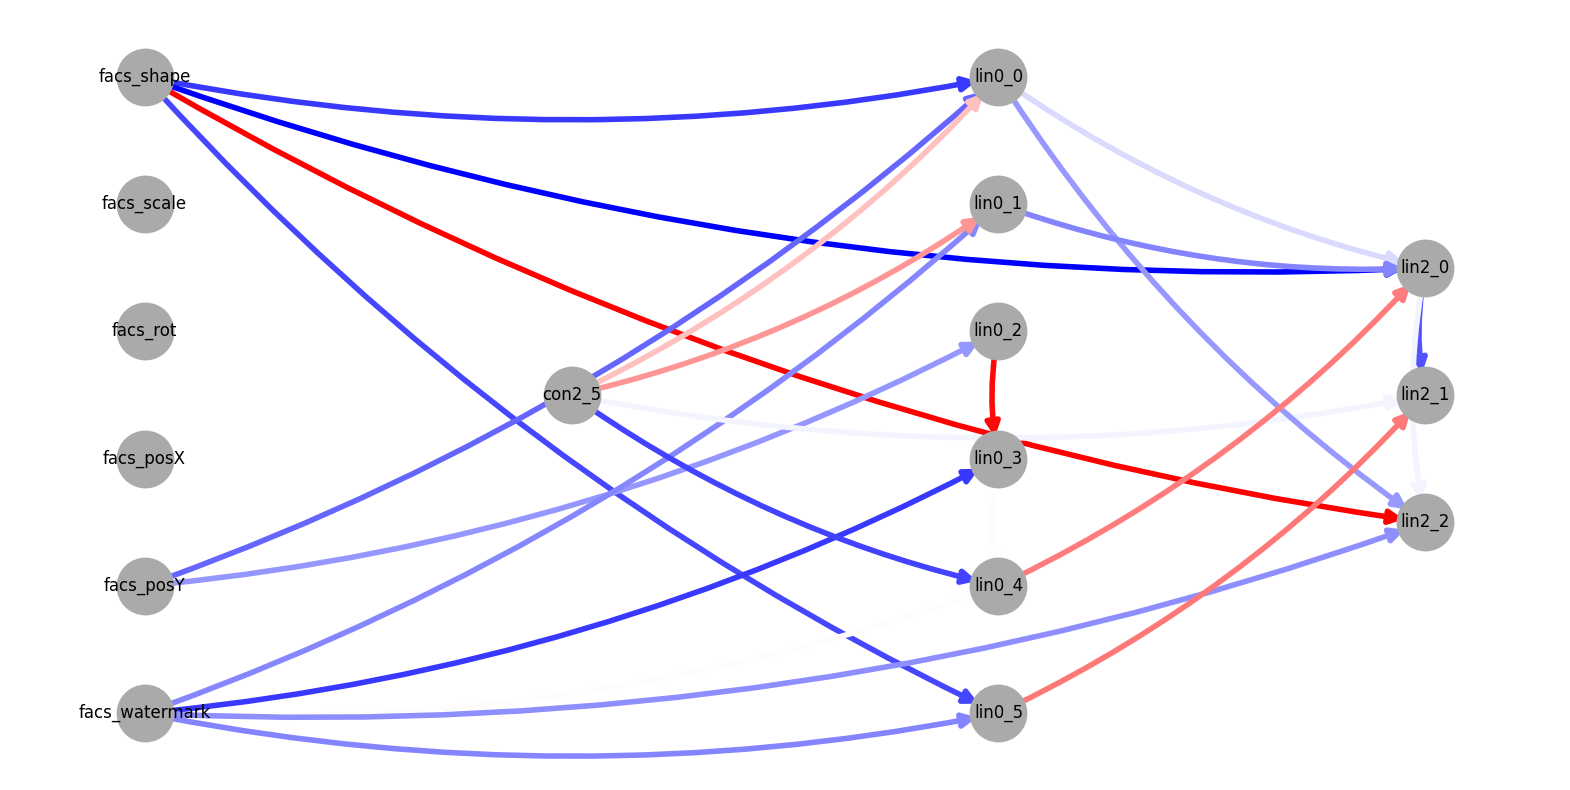

In [55]:
plot_multipartite(results, layers)

In [35]:
np.save("shape_all_graph_unbiased.npy", results["graph"])
np.save("shape_all_values_unbiased.npy", results["val_matrix"])

In [68]:
sample_size = 50

indices = {0: {0: [], 1:[]},1: {0: [], 1:[]},2: {0: [], 1:[]}}
ds = datasets["test_unbiased"]["ds"]
for i in range(sample_size* 10):
    index = np.random.randint(0, len(ds))
    latents, watermark = ds.get_item_info(index)
    if len(indices[latents[0]][int(watermark)]) < sample_size:
        indices[latents[0]][int(watermark)] += [index]
print([len(indices[i][j]) for i in range(3) for j in range(2)])

[50, 50, 50, 50, 50, 50]


In [239]:
from matplotlib.colors import TwoSlopeNorm

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {name: cc for name in layer_names}


def draw_graph(nodes, connections, ax=None, vmin=-1.0, vmax=1.0):
    edges = [
        (i, j, dict(weight=connections[i][j]))
        for i in connections.keys()
        for j in connections[i].keys()
        if connections[i][j] != 0
    ]
    edges = sorted(edges)
    nodes = sorted(nodes)
    subsets = {i: i[0:-2] for i in nodes}

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for i, j, data in edges:
        if data["weight"] != 0:
            label = (
                str(round(data["weight"], 3)) if np.abs(data["weight"]) >= 0.01 else ""
            )
            G.add_edge(i, j, weight=data["weight"], label=label)

    weights = {(i, j): l for i, j, l in G.edges.data("weight")}
    labels = {(i, j): l for i, j, l in G.edges.data("label")}
    colors = np.array(list(weights.values()), dtype=np.float64)
    # colors = (colors - vmin) / vmax
    norm = TwoSlopeNorm(vcenter=-0.0)  # , vmin=vmin, vmax=vmax)
    colors = norm(colors)
    # [ 1  if  i > 0 else 0 for i in weights.values()]

    for n in G.nodes:
        if n[0] not in ["c", "l"]:
            G.nodes[n]["subset"] = "pred"
        else:
            G.nodes[n]["subset"] = subsets[n]
    pos = nx.multipartite_layout(G, subset_key="subset")
    if ax is None:
        fig = plt.figure(figsize=(30, 10))
        ax = fig.add_subplot(111, frame_on=False)
    nx.draw_networkx(
        G,
        ax=ax,
        pos=pos,
        node_size=1000,
        linewidths=0,
        width=5,
        node_color="#bbb",
        node_shape="s",
        arrowstyle="->",
        arrowsize=20,
        edge_cmap=mpl.cm.coolwarm,
        edge_color=colors,
        connectionstyle="arc,rad=0.1",
        with_labels=False,
    )
    nx.draw_networkx_edge_labels(
        G,
        ax=ax,
        pos=pos,
        edge_labels=labels,
        label_pos=0.35,
        clip_on=False,
        verticalalignment="baseline",
        bbox={"fc": "white", "alpha": 0.0, "ec": "white"},
    )
    nx.draw_networkx_labels(
        G, ax=ax, pos=pos, font_size=14, bbox={"ec": "#555", "fc": "#bbb", "alpha": 0.5}
    )

In [252]:
names = {
    "linear_layers.2_0": "0_rectangle",
    "linear_layers.2_1": "1_ellipse",
    "linear_layers.2_2": "2_heart",
}


def make_relevance_graph(ds, index):
    # latents, watermark = ds.get_item_info(index)
    # only specific shape
    img, _ = ds[index]
    sample = img.view(1, 1, 64, 64)
    with torch.no_grad():
        output = model(sample)
        pred = int(output.data.max(1)[1][0])
    sample.requires_grad = True

    graph = trace_model_graph(model, sample, layer_names)
    attgraph = AttributionGraph(attribution, graph, layer_map)
    # width=[5, 2] returns first the 5 most relevant concepts in the previous lower-level layer
    # and in the second iteration returns for each of the 5 most relevant concepts again the two
    # most relevant concepts in the previous lower-level layer
    nodes, connections = attgraph(
        sample,
        composite,
        pred,
        "linear_layers.2",
        width=[6, 6, 6],
        abs_norm=True,
        verbose=False,
        batch_size=1,
    )
    edges = {}
    for i in connections.keys():
        name = (
            names[f"{i[0]}_{i[1]}"] if f"{i[0]}_{i[1]}" in names else f"{i[0]}_{i[1]}"
        )
        edges[name] = {f"{j[0]}_{j[1]}": j[2] for j in connections[i]}

    node_labels = [
        names[f"{i[0]}_{i[1]}"] if f"{i[0]}_{i[1]}" in names else f"{i[0]}_{i[1]}"
        for i in nodes
    ]
    return node_labels, edges

In [258]:
def average_hierarchies(indices):
    relevance_graphs = {
        0: {0: {}, 1: {}},
        1: {0: {}, 1: {}},
        2: {0: {}, 1: {}},
        "nodes": set(),
    }
    cluster_data = {}
    for l in indices.keys():
        for w in indices[l].keys():
            for i in range(len(indices[l][w])):
                nodes, edges = make_relevance_graph(ds, indices[l][w][i])
                relevance_graphs["nodes"].update(nodes)
                for s in edges.keys():
                    if s not in relevance_graphs[l][w]:
                        relevance_graphs[l][w][s] = {}
                    for t in edges[s].keys():
                        val = edges[s][t] / sample_size
                        if (s,t) not in cluster_data:
                            cluster_data[(s,t)] = [val]
                        else:
                            cluster_data[(s,t)] += [val]
                        if val != 0:
                            if t not in relevance_graphs[l][w][s]:
                                relevance_graphs[l][w][s][t] = val
                            else:
                                relevance_graphs[l][w][s][t] += val
    return relevance_graphs, cluster_data

In [259]:
rele, cluster_data = average_hierarchies(indices)
values = [rele[i][j][n][sub] for i in [0,1,2] for j in [0,1]  for n in rele[i][j].keys() for sub in rele[i][j][n]]
values = np.array(values).flatten()
min_relevance = min(values)
max_relevance= max(values)
print(min_relevance, max_relevance, cluster_data)

-1.0000000000000004 1.0000000000000004 {('0_rectangle', 'linear_layers.0_4'): [0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013601183891296387, 0.013004488945007324, 0.013004488945007324, 0.013591954708099365, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.013004488945007324, 0.01300448894500732

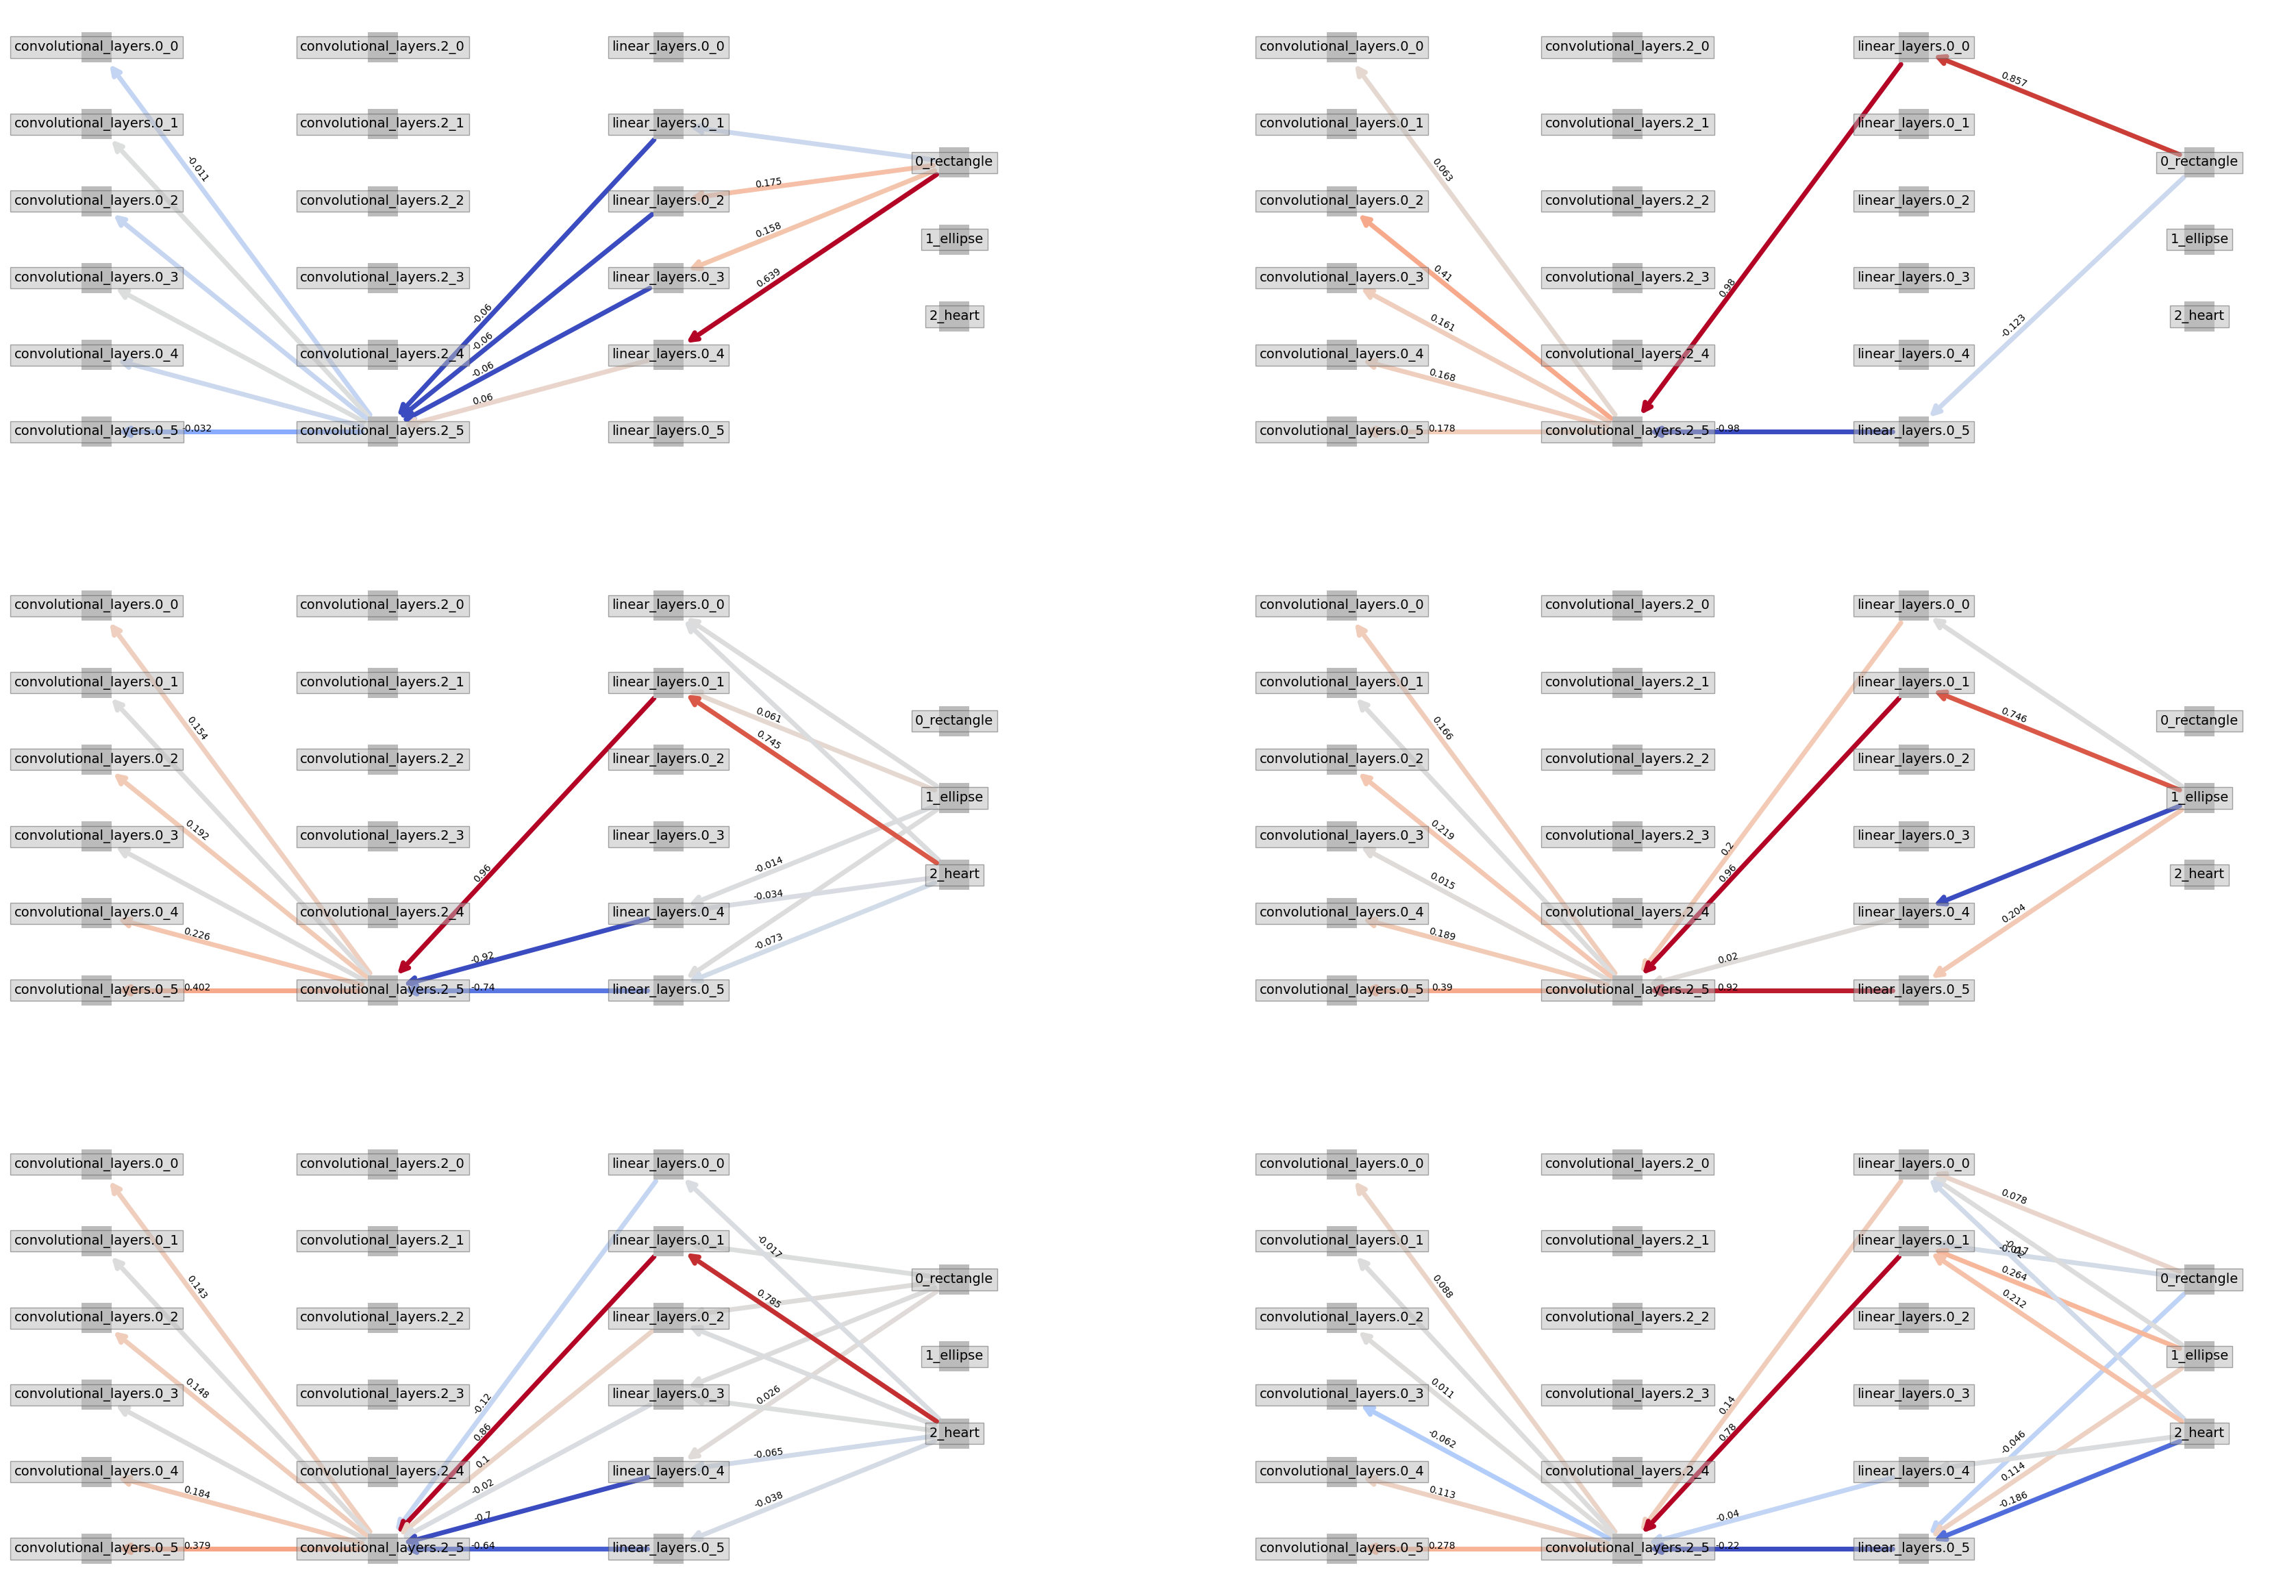

In [254]:
fig = plt.figure(figsize=(43, 30))

ax0 = fig.add_subplot(321, frame_on=False)
ax1 = fig.add_subplot(322, frame_on=False)
ax2 = fig.add_subplot(323, frame_on=False)
ax3 = fig.add_subplot(324, frame_on=False)
ax4 = fig.add_subplot(325, frame_on=False)
ax5 = fig.add_subplot(326, frame_on=False)
draw_graph(list(rele["nodes"]), rele[0][0], ax0, min_relevance, max_relevance)
draw_graph(list(rele["nodes"]), rele[0][1], ax1, min_relevance, max_relevance)
draw_graph(list(rele["nodes"]), rele[1][0], ax2, min_relevance, max_relevance)
draw_graph(list(rele["nodes"]), rele[1][1], ax3, min_relevance, max_relevance)
draw_graph(list(rele["nodes"]), rele[2][0], ax4, min_relevance, max_relevance)
draw_graph(list(rele["nodes"]), rele[2][1], ax5, min_relevance, max_relevance)

In [159]:
import json
with open("hierarchies_unbiased.json", "+w") as f:
    rele["nodes"] = list(rele["nodes"])
    json.dump(rele, f)

In [50]:
with open("hierarchies_biased.json", "+w") as f:
    rele = json.load(f)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

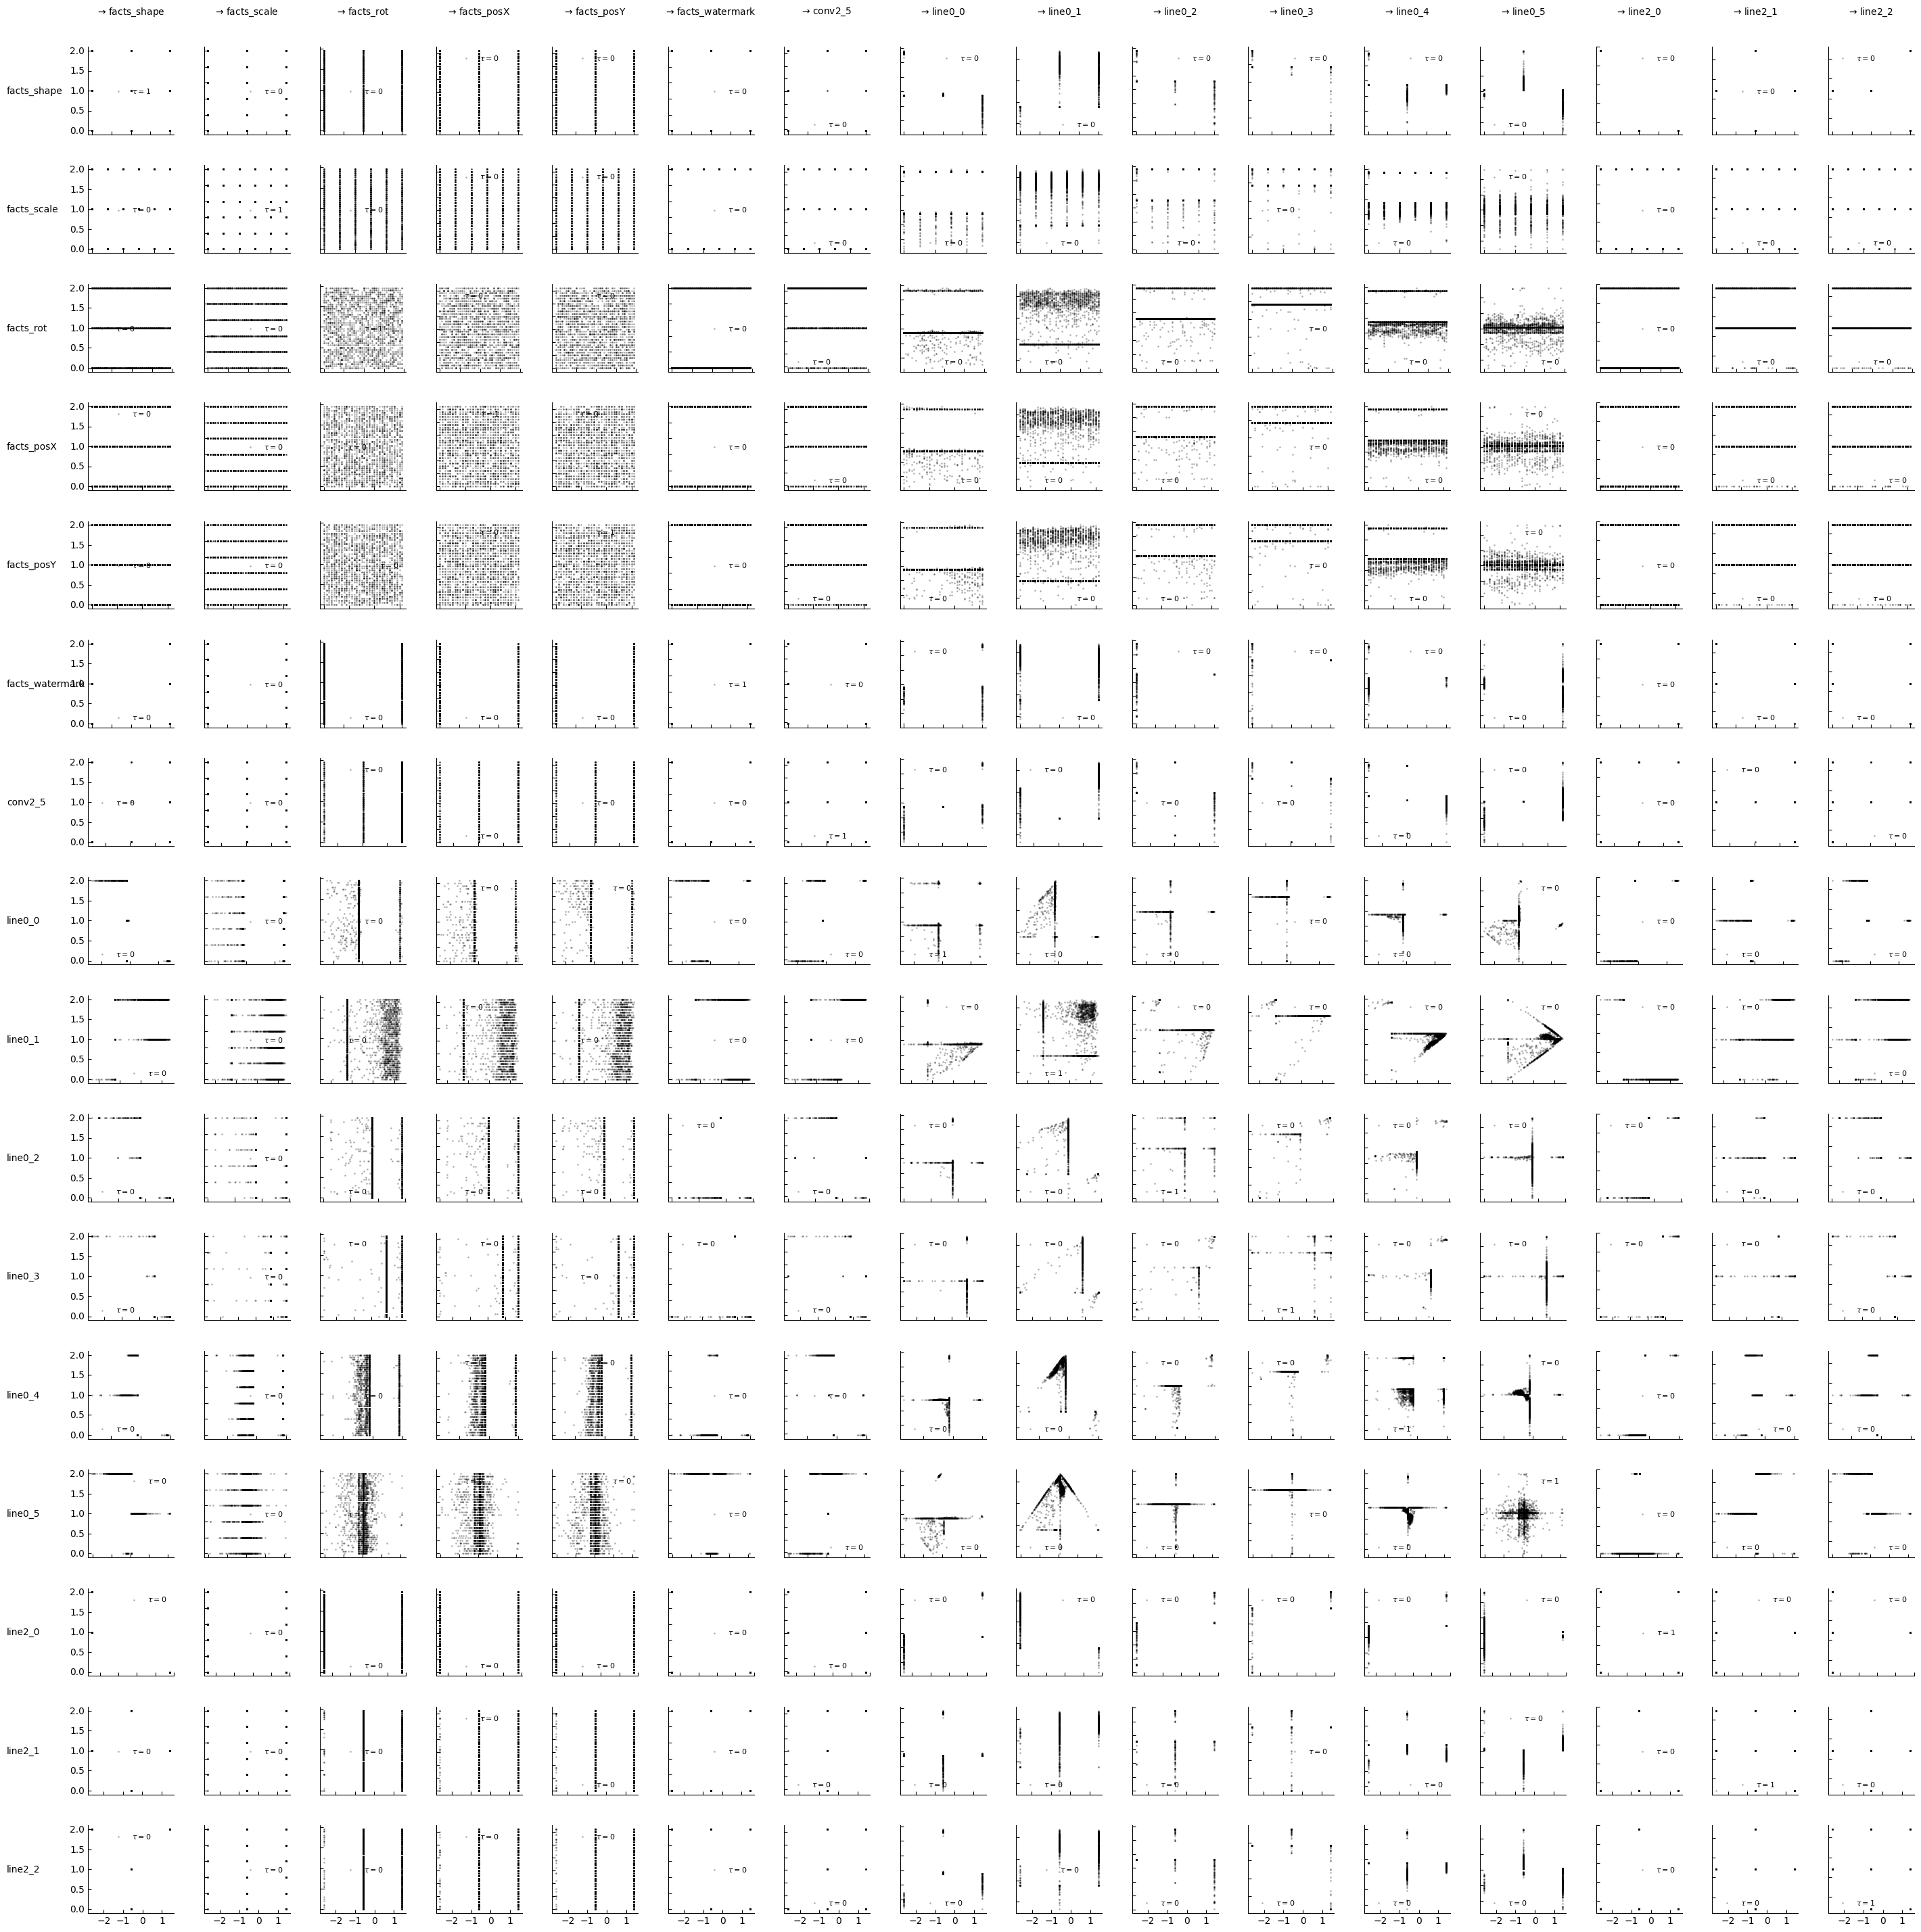

In [44]:
setup_args = {"figsize": (30,30),"label_space_left": 0.05,"label_space_top": 0.03}
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':None}, 
                    setup_args=setup_args); plt.show()

In [44]:

from torch.autograd import Variable
import torch.nn.functional as F

def accuracy(model, loader):
    model.eval()
    losses = []
    correct = 0
    with torch.no_grad():
        for item in tqdm(loader):
            data, target = Variable(item[0]), Variable(item[1])
            output = model(data)
            losses.append(F.cross_entropy(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    eval_loss = float(np.mean(losses))
    return eval_loss, 100. * correct / len(loader.dataset)


def accuracy_per_class(model, loader):
    model.eval()
    n_classes = 3
    correct = np.zeros(n_classes, dtype=np.int64)
    wrong = np.zeros(n_classes, dtype=np.int64)
    with torch.no_grad():
        for item in tqdm(loader):
            data, target = Variable(item[0]), Variable(item[1])
            output = model(data)
            preds = output.data.max(dim=1)[1].cpu().numpy().astype(np.int64)
            t = target.data.cpu().numpy().astype(np.int64)
            for label, pred in zip(target, preds):
                if label == pred:
                    correct[label] += 1
                else:
                    wrong[label] += 1
    assert correct.sum() + wrong.sum() == len(loader.dataset)
    return 100. * correct / (correct + wrong)

In [45]:
test_biased_acc_per_class = accuracy_per_class(model, datasets["test_biased"]["loader"])
test_unbiased_acc_per_class = accuracy_per_class(
    model, datasets["test_unbiased"]["loader"]
)
no_watermark_acc_per_class = accuracy_per_class(
    model, datasets["no_watermark"]["loader"]
)
test_biased_acc = accuracy(model, datasets["test_biased"]["loader"])
test_unbiased_acc = accuracy(model, datasets["test_unbiased"]["loader"])
no_watermark_acc = accuracy(model, datasets["no_watermark"]["loader"]) 

def to_per(arr):
    return ", ".join([f'{np.round(i, 3)}%' for i in arr])

print(
    f"Biased test dataset accuracy per class: {to_per(test_biased_acc_per_class)} total accuracy:  {np.round(test_biased_acc[1], 2)}% \n \
    Uniased test dataset accuracy per class: {to_per(test_unbiased_acc_per_class)} total accuracy:  {np.round(test_unbiased_acc[1], 2)}%  \n \
    Test dataset without watermark accuracy per class: {to_per(no_watermark_acc_per_class)} total accuracy:  {np.round(no_watermark_acc[1], 2)}% "
)

100%|██████████| 3417/3417 [02:06<00:00, 27.05it/s]

Biased test dataset accuracy per class: 99.888%, 99.443%, 98.82% total accuracy:  99.38% 
     Uniased test dataset accuracy per class: 99.906%, 99.521%, 98.774% total accuracy:  99.4%  
     Test dataset without watermark accuracy per class: 99.91%, 99.557%, 98.843% total accuracy:  99.44% 
